# Linear Regression with Statsmodels for Movie Revenue

- 05/10/22

## Activity: Create a Linear Regression Model with Statsmodels for Revenue

- Today we will be working with JUST the data data from the TMDB API for years 2000-2021. 
    - We will prepare the data for modeling
        - Some feature engineering
        - Our usual Preprocessing
        - New steps for statsmodels!
    - We will fit a statsmodels linear regression.
    - We Will inspect the model summary.
    - We will create the visualizations to check assumptions about the residuals.



- Next class we will continue this activity.
    - We will better check all 4 assumptions.
    - We will discuss tactics for dealing with violations of the assumptions. 
    - We will use our coefficients to make stakeholder recommendations.

### Concepts Demonstrated

- [ ] Using `glob` for loading in all final files. 
- [ ] Statsmodels OLS
- [ ] QQ-Plot
- [ ] Residual Plot

# Loading the Data

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

In [2]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [3]:
## Checking what data we already in our Data folder using os.listdir
import os
FOLDER = 'Data/'
file_list = sorted(os.listdir(FOLDER))
file_list

['.DS_Store',
 '.ipynb_checkpoints',
 '2010-2021',
 'combined_tmdb_data.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'final_tmdb_data_2003.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'final_tmdb_data_2005.csv.gz',
 'final_tmdb_data_2006.csv.gz',
 'final_tmdb_data_2007.csv.gz',
 'final_tmdb_data_2008.csv.gz',
 'final_tmdb_data_2009.csv.gz',
 'title_akas_cleaned.csv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2002.json',
 'tmdb_api_results_2003.json',
 'tmdb_api_results_2004.json',
 'tmdb_api_results_2005.json',
 'tmdb_api_results_2006.json',
 'tmdb_api_results_2007.json',
 'tmdb_api_results_2008.json',
 'tmdb_api_results_2009.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2012.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 'tmdb_a

In [4]:
# ## Try loading in the first .csv.gz file from the list
# pd.read_csv(file_list[4])

> Why isn't it working?

In [5]:
## let's check the filepath 
FOLDER+file_list[4]

'Data/final_tmdb_data_2000.csv.gz'

In [6]:
## add the folder plus filename
pd.read_csv(FOLDER+file_list[4])

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,2.491,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.4,21.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,1.974,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,4.4,7.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",1.341,/yB5wRu4uyXXwZA3PEj8cITu0xt3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",22.411,/iYypPT4bhqXfq1b6EnmxvRt6b2Y.jpg,"[{'id': 539, 'logo_path': None, 'name': 'Block...","[{'iso_3166_1': 'CN', 'name': 'China'}, {'iso_...",2000-09-29,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1868.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,tt6174238,0.0,NaN,"{'id': 404302, 'name': 'Cold War Collection', ...",0.0,"[{'id': 80, 'name': 'Crime'}]",NaN,223878.0,en,Cold War,"Since the death of his wife three years ago, K...",0.913,/4p58ILmqsfPGS9iRCX3riekJt8e.jpg,[],"[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}]",2000-06-17,0.0,0.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Cold War,0.0,2.0,2.0,NaN
1194,tt7029820,0.0,NaN,NaN,0.0,[],NaN,604889.0,en,Scream For Christmas,A Christmas party is interrupted by a violent ...,0.600,NaN,[],[],NaN,0.0,80.0,[],Released,NaN,Scream For Christmas,0.0,0.0,0.0,NaN
1195,tt7197642,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,872676.0,en,"Goodbye, Merry-Go-Round",Maryland comedy,0.600,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2000-12-12,0.0,90.0,[],Released,NaN,"Goodbye, Merry-Go-Round",0.0,0.0,0.0,NaN
1196,tt7631368,0.0,/sF0gUHE0YzZNXYugTB2LFxJIppf.jpg,NaN,10000000.0,"[{'id': 27, 'name': 'Horror'}]",NaN,97186.0,fr,"I, Vampire",A sensual trilogy of vampire stories from Wiza...,0.987,/cl47LE7zYELjTzH7gfyvzBrCG5W.jpg,[],[],2000-10-17,0.0,85.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,"I, Vampire",0.0,6.4,4.0,NR


- Now we would do that in a loop, and only want to open .csv.gz.
- But there is a better way!
>- Introducing `glob`
    - Glob takes a filepath/query and will find every filename that matches the pattern provided.
    - We use asterisks as wildcards in our query.
    


In [7]:
import glob
## Make a filepath query
q = FOLDER+"final*.csv.gz"
print(q)
file_list = sorted(glob.glob(q))
file_list


Data/final*.csv.gz


['Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz']

In [8]:
# Use glob.glob to get COMPLETE filepaths
q = FOLDER+"/**/final*.csv.gz"
print(q)
file_list = sorted(glob.glob(q,recursive=True))
file_list


Data//**/final*.csv.gz


['Data/2010-2021/final_tmdb_data_2010.csv.gz',
 'Data/2010-2021/final_tmdb_data_2011.csv.gz',
 'Data/2010-2021/final_tmdb_data_2012.csv.gz',
 'Data/2010-2021/final_tmdb_data_2013.csv.gz',
 'Data/2010-2021/final_tmdb_data_2014.csv.gz',
 'Data/2010-2021/final_tmdb_data_2015.csv.gz',
 'Data/2010-2021/final_tmdb_data_2016.csv.gz',
 'Data/2010-2021/final_tmdb_data_2017.csv.gz',
 'Data/2010-2021/final_tmdb_data_2018.csv.gz',
 'Data/2010-2021/final_tmdb_data_2019.csv.gz',
 'Data/2010-2021/final_tmdb_data_2020.csv.gz',
 'Data/2010-2021/final_tmdb_data_2021.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz']

> But where are the rest of the years?

- Recursive Searching with glob.
    - add a `**/` in the middle of your query to grab any matches from all subfolders. 

In [9]:
# # ## use a list comprehension to load in all files into 1 dataframe
# df_list = []

# for file in file_list:
#     df = pd.read_csv(file)
#     df_list.append(df)

- Dealing with ParserErrors with "possibly malformed files"

    - for a reason I do not fully understand yet, some of the files I downloaded error if I try to read them.
        - "ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.`
    - After some googling, the fix was to add `lineterminator='\n'` to pd.read_csv


In [10]:
# df_list[0]

In [11]:
## use a list comprehension to load in all files into 1 dataframe
# ## use a list comprehension to load in all files into 1 dataframe
df_list = []

for file in file_list:
    df = pd.read_csv(file, lineterminator="\n")
    df_list.append(df)
    
df = pd.concat(df_list)
df.reset_index(inplace=True,drop=True)
# df

In [12]:
df = pd.concat([pd.read_csv(file, lineterminator="\n") for file in file_list])
df.reset_index(inplace=True, drop=True)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60147,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60148,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60149,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60150,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


### Filtering

- Make sure to only keep:
    0. Movies with actual imdb_id's (!="0")
    1. Status=Released.
    2. Budget >0
    3. Revenue >0

In [13]:
# remove ids that are 0  and then reset index
df = df[df['imdb_id'] != '0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60147,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60148,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60149,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60150,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


### New 06/12/22

<AxesSubplot:>

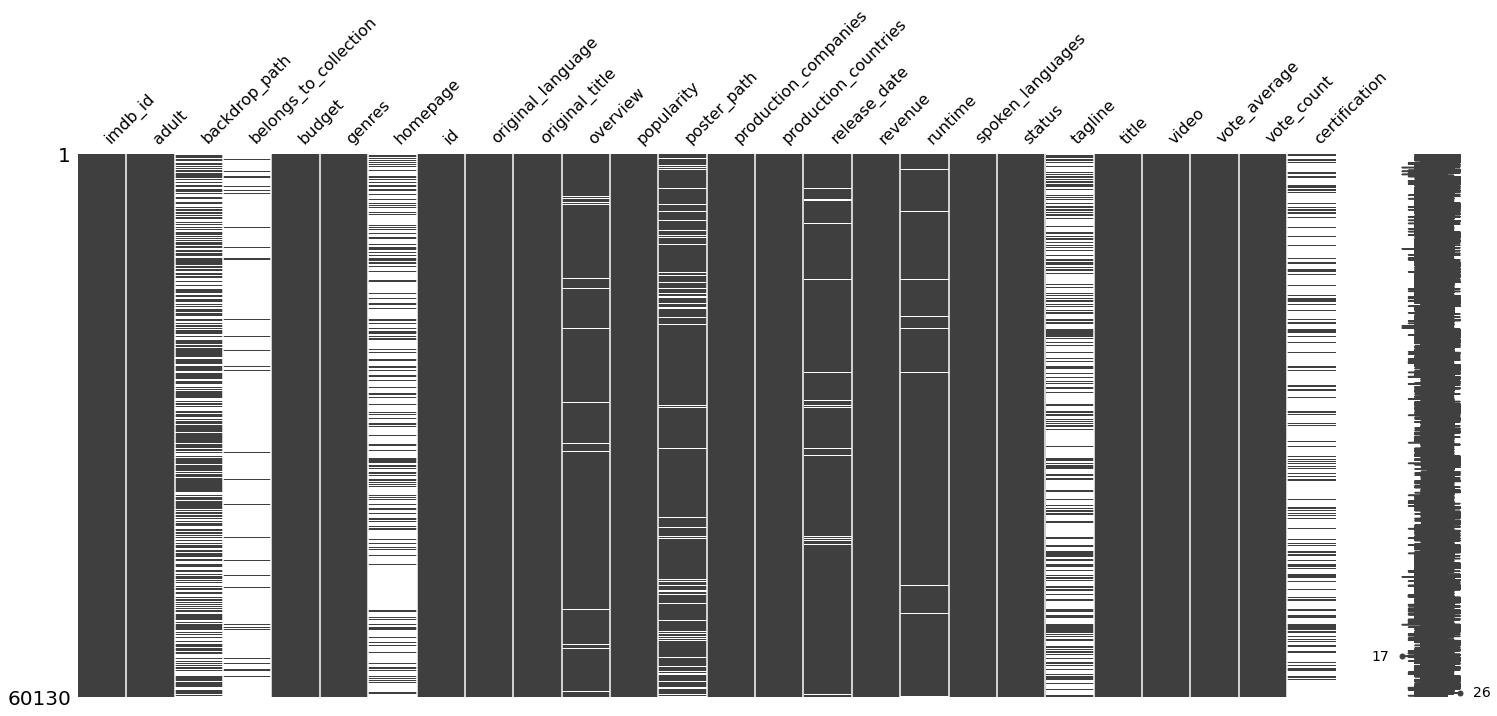

In [14]:
import missingno
missingno.matrix(df)

In [15]:
## Check status
df['status'].value_counts()

Released           60097
Post Production       27
In Production          6
Name: status, dtype: int64

In [16]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60147,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60148,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],NaN,Tattoo,0.0,5.0,1.0,NaN
60149,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60150,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


In [17]:
(df['revenue'] ==0).sum()/len(df)

0.8762500623991214

In [18]:
df.loc[(df['budget'] >0 ) & (df['revenue']>0)]

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,5.924617e+08,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
7,tt0411951,0.0,/rbB7g8YBFMLKtmwB8QEvVlKh5Yh.jpg,"{'id': 294172, 'name': 'Tekken Collection', 'p...",30000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,42194.0,en,Tekken,"In the year of 2039, after World Wars destroy ...",70.694,/1xO2LirDZstkqZic1FwfK6GJIHH.jpg,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-03-20,9.670000e+05,92.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Survival is no game,Tekken,0.0,5.4,553.0,R
10,tt0427152,0.0,/2bNvoxVPyfiuNh7vmRvwePY5Paf.jpg,NaN,69000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.dinnerforschmucks.com/,38778.0,en,Dinner for Schmucks,Rising executive Tim Conrad works for a boss w...,21.747,/djwkUFhkM81gIsI9ZZ7I6ajZAKY.jpg,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-07-30,8.638786e+07,114.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Takes One To Know One.,Dinner for Schmucks,0.0,5.6,1452.0,PG-13
11,tt0429493,0.0,/hy1QuQa0sCJAmVAVySYZpMk1okk.jpg,NaN,110000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",https://www.20thcenturystudios.com/movies/the-...,34544.0,en,The A-Team,A group of Iraq War veterans goes on the run f...,56.494,/bkAWEx5g5tvRPjtDQyvIZ7LRxQm.jpg,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-09,1.772388e+08,117.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",There Is No Plan B,The A-Team,0.0,6.4,3877.0,PG-13
12,tt0435761,0.0,/wE5JGzujfvDPMIfFjJyrhXFjZLc.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/toystory/,10193.0,en,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",93.983,/AbbXspMOwdvwWZgVN0nabZq03Ec.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-16,1.066970e+09,103.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No toy gets left behind.,Toy Story 3,0.0,7.8,12455.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59881,tt1532382,0.0,/mLajVFwUGjmCvjLP53iPrTJ5Yk5.jpg,"{'id': 106790, 'name': 'Hooked Collection', 'p...",3500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,37656.0,ru,На игре,After a stunning victory at a cyber sport tour...,4.838,/9RSVyIwttjIMcCOgpszmkXka5wt.jpg,[],"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2009-11-26,3.704408e+06,97.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",NaN,Hooked on the Game,0.0,6.3,42.0,NaN
59909,tt1542960,0.0,/tPgyX4Y03VHywSwMrMsQzF7Syc0.jpg,NaN,300000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",https://en.wikipedia.org/wiki/The_Figurine,381961.0,en,Araromire,"Two buddies and a girl, down on their luck, ha...",1.937,/uwFNP7jSpCy2sKXsj2dJwJi5r1l.jpg,"[{'id': 46722, 'logo_path': None, 'name': 'Gol...","[{'iso_3166_1': 'NG', 'name': 'Nigeria'}]",2009-10-02,2.000000e+05,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No one told them about the next seven years...,The Figurine (Araromire),0.0,4.2,11.0,NaN
59945,tt1560950,0

In [19]:
# filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,5.924617e+08,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
7,tt0411951,0.0,/rbB7g8YBFMLKtmwB8QEvVlKh5Yh.jpg,"{'id': 294172, 'name': 'Tekken Collection', 'p...",30000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,42194.0,en,Tekken,"In the year of 2039, after World Wars destroy ...",70.694,/1xO2LirDZstkqZic1FwfK6GJIHH.jpg,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-03-20,9.670000e+05,92.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Survival is no game,Tekken,0.0,5.4,553.0,R
10,tt0427152,0.0,/2bNvoxVPyfiuNh7vmRvwePY5Paf.jpg,NaN,69000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.dinnerforschmucks.com/,38778.0,en,Dinner for Schmucks,Rising executive Tim Conrad works for a boss w...,21.747,/djwkUFhkM81gIsI9ZZ7I6ajZAKY.jpg,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-07-30,8.638786e+07,114.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Takes One To Know One.,Dinner for Schmucks,0.0,5.6,1452.0,PG-13
11,tt0429493,0.0,/hy1QuQa0sCJAmVAVySYZpMk1okk.jpg,NaN,110000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",https://www.20thcenturystudios.com/movies/the-...,34544.0,en,The A-Team,A group of Iraq War veterans goes on the run f...,56.494,/bkAWEx5g5tvRPjtDQyvIZ7LRxQm.jpg,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-09,1.772388e+08,117.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",There Is No Plan B,The A-Team,0.0,6.4,3877.0,PG-13
12,tt0435761,0.0,/wE5JGzujfvDPMIfFjJyrhXFjZLc.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/toystory/,10193.0,en,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",93.983,/AbbXspMOwdvwWZgVN0nabZq03Ec.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-16,1.066970e+09,103.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No toy gets left behind.,Toy Story 3,0.0,7.8,12455.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59881,tt1532382,0.0,/mLajVFwUGjmCvjLP53iPrTJ5Yk5.jpg,"{'id': 106790, 'name': 'Hooked Collection', 'p...",3500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,37656.0,ru,На игре,After a stunning victory at a cyber sport tour...,4.838,/9RSVyIwttjIMcCOgpszmkXka5wt.jpg,[],"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2009-11-26,3.704408e+06,97.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",NaN,Hooked on the Game,0.0,6.3,42.0,NaN
59909,tt1542960,0.0,/tPgyX4Y03VHywSwMrMsQzF7Syc0.jpg,NaN,300000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",https://en.wikipedia.org/wiki/The_Figurine,381961.0,en,Araromire,"Two buddies and a girl, down on their luck, ha...",1.937,/uwFNP7jSpCy2sKXsj2dJwJi5r1l.jpg,"[{'id': 46722, 'logo_path': None, 'name': 'Gol...","[{'iso_3166_1': 'NG', 'name': 'Nigeria'}]",2009-10-02,2.000000e+05,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No one told them about the next seven years...,The Figurine (Araromire),0.0,4.2,11.0,NaN
59945,tt1560950,0

In [20]:
# Formatting Numbers with Comma Delinearator
# https://www.markhneedham.com/blog/2021/04/11/pandas-format-dataframe-numbers-commas-decimals/

In [21]:
df.describe()[['revenue','budget']].style.format('{:,.2f}')

,revenue,budget
count,"5,090.00","5,090.00"
mean,"93,344,152.72","33,045,203.83"
std,"189,497,104.31","44,604,165.15"
min,1.00,1.00
25%,"3,788,994.50","5,000,000.00"
50%,"24,640,055.50","16,000,000.00"
75%,"94,422,826.50","40,000,000.00"
max,"2,847,246,203.00","380,000,000.00"


- Weird values for the low end of the revneue/budget. 
    - Compare the min to the first quartile (25%)

In [22]:
(df['budget'] < 100000).sum()

177

In [23]:
(df['revenue'] < 100000).sum()

330

> Only keeping movies with budgets and revenue > $100K

In [24]:
plot_df = df.loc[ (df['budget']>=100_000) & (df['revenue']>=100_000)]
plot_df# = df.loc[ df['budget']>100_000]

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,5.924617e+08,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
7,tt0411951,0.0,/rbB7g8YBFMLKtmwB8QEvVlKh5Yh.jpg,"{'id': 294172, 'name': 'Tekken Collection', 'p...",30000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,42194.0,en,Tekken,"In the year of 2039, after World Wars destroy ...",70.694,/1xO2LirDZstkqZic1FwfK6GJIHH.jpg,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-03-20,9.670000e+05,92.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Survival is no game,Tekken,0.0,5.4,553.0,R
10,tt0427152,0.0,/2bNvoxVPyfiuNh7vmRvwePY5Paf.jpg,NaN,69000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.dinnerforschmucks.com/,38778.0,en,Dinner for Schmucks,Rising executive Tim Conrad works for a boss w...,21.747,/djwkUFhkM81gIsI9ZZ7I6ajZAKY.jpg,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-07-30,8.638786e+07,114.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Takes One To Know One.,Dinner for Schmucks,0.0,5.6,1452.0,PG-13
11,tt0429493,0.0,/hy1QuQa0sCJAmVAVySYZpMk1okk.jpg,NaN,110000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",https://www.20thcenturystudios.com/movies/the-...,34544.0,en,The A-Team,A group of Iraq War veterans goes on the run f...,56.494,/bkAWEx5g5tvRPjtDQyvIZ7LRxQm.jpg,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-09,1.772388e+08,117.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",There Is No Plan B,The A-Team,0.0,6.4,3877.0,PG-13
12,tt0435761,0.0,/wE5JGzujfvDPMIfFjJyrhXFjZLc.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/toystory/,10193.0,en,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",93.983,/AbbXspMOwdvwWZgVN0nabZq03Ec.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-16,1.066970e+09,103.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No toy gets left behind.,Toy Story 3,0.0,7.8,12455.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59652,tt1467391,0.0,/mpjCRn3iZRD9Z8op9w7hvj7ImlK.jpg,NaN,33000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.spanishmovie.es,35640.0,es,Spanish Movie,"Grandes dosis de humor, ingeniosos guiños a nu...",7.673,/uUW7KgUKBi83kU0tlBJLYwdY4ZR.jpg,"[{'id': 10128, 'logo_path': '/apcQLKRuLLqhi9fD...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",2009-12-04,6.982465e+06,83.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",NaN,Spanish Movie,0.0,4.9,131.0,NaN
59881,tt1532382,0.0,/mLajVFwUGjmCvjLP53iPrTJ5Yk5.jpg,"{'id': 106790, 'name': 'Hooked Collection', 'p...",3500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,37656.0,ru,На игре,After a stunning victory at a cyber sport tour...,4.838,/9RSVyIwttjIMcCOgpszmkXka5wt.jpg,[],"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2009-11-26,3.704408e+06,97.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",NaN,Hooked on the Game,0.0,6.3,42.0,NaN
59909,tt1542960,0.0,/tPgyX4Y03VHywSwMrMsQzF7Syc0.jpg,NaN,300000.0,"[{'id': 18, 'name': 'Drama'}, {'id':

In [25]:
plot_df.describe()[['revenue','budget']].style.format('{:,.2f}')

,revenue,budget
count,"4,714.00","4,714.00"
mean,"100,730,849.01","35,443,486.79"
std,"195,003,963.07","45,470,211.21"
min,"100,000.00","100,000.00"
25%,"6,487,071.00","6,500,000.00"
50%,"30,531,261.00","19,600,000.00"
75%,"102,849,823.75","44,376,250.00"
max,"2,847,246,203.00","380,000,000.00"


<AxesSubplot:xlabel='budget', ylabel='Count'>

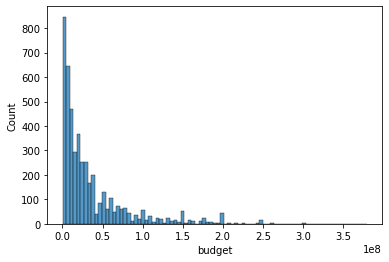

In [26]:
sns.histplot(data=plot_df, x='budget')

<AxesSubplot:xlabel='revenue', ylabel='Count'>

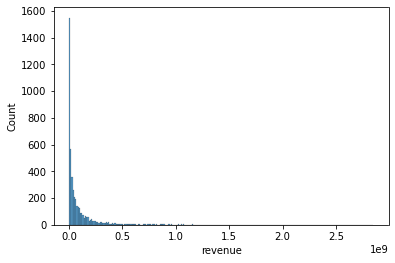

In [27]:
sns.histplot(data=plot_df, x='revenue')

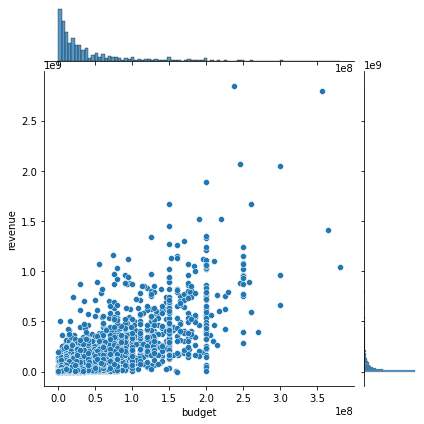

In [28]:
ax = sns.jointplot(data=plot_df, x='budget', y='revenue')


In [29]:
## saving the combined csv to disk

df = plot_df.copy()
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,video,vote_average,vote_count,certification
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,5.924617e+08,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
7,tt0411951,0.0,/rbB7g8YBFMLKtmwB8QEvVlKh5Yh.jpg,"{'id': 294172, 'name': 'Tekken Collection', 'p...",30000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,42194.0,en,Tekken,"In the year of 2039, after World Wars destroy ...",70.694,/1xO2LirDZstkqZic1FwfK6GJIHH.jpg,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-03-20,9.670000e+05,92.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Survival is no game,Tekken,0.0,5.4,553.0,R
10,tt0427152,0.0,/2bNvoxVPyfiuNh7vmRvwePY5Paf.jpg,NaN,69000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.dinnerforschmucks.com/,38778.0,en,Dinner for Schmucks,Rising executive Tim Conrad works for a boss w...,21.747,/djwkUFhkM81gIsI9ZZ7I6ajZAKY.jpg,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-07-30,8.638786e+07,114.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Takes One To Know One.,Dinner for Schmucks,0.0,5.6,1452.0,PG-13
11,tt0429493,0.0,/hy1QuQa0sCJAmVAVySYZpMk1okk.jpg,NaN,110000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",https://www.20thcenturystudios.com/movies/the-...,34544.0,en,The A-Team,A group of Iraq War veterans goes on the run f...,56.494,/bkAWEx5g5tvRPjtDQyvIZ7LRxQm.jpg,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-09,1.772388e+08,117.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",There Is No Plan B,The A-Team,0.0,6.4,3877.0,PG-13
12,tt0435761,0.0,/wE5JGzujfvDPMIfFjJyrhXFjZLc.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/toystory/,10193.0,en,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",93.983,/AbbXspMOwdvwWZgVN0nabZq03Ec.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-06-16,1.066970e+09,103.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",No toy gets left behind.,Toy Story 3,0.0,7.8,12455.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59652,tt1467391,0.0,/mpjCRn3iZRD9Z8op9w7hvj7ImlK.jpg,NaN,33000000.0,"[{'id': 35, 'name': 'Comedy'}]",http://www.spanishmovie.es,35640.0,es,Spanish Movie,"Grandes dosis de humor, ingeniosos guiños a nu...",7.673,/uUW7KgUKBi83kU0tlBJLYwdY4ZR.jpg,"[{'id': 10128, 'logo_path': '/apcQLKRuLLqhi9fD...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",2009-12-04,6.982465e+06,83.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",NaN,Spanish Movie,0.0,4.9,131.0,NaN
59881,tt1532382,0.0,/mLajVFwUGjmCvjLP53iPrTJ5Yk5.jpg,"{'id': 106790, 'name': 'Hooked Collection', 'p...",3500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,37656.0,ru,На игре,After a stunning victory at a cyber sport tour...,4.838,/9RSVyIwttjIMcCOgpszmkXka5wt.jpg,[],"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2009-11-26,3.704408e+06,97.0,"[{'english_name': 'Russian', 'iso_639_1': 'ru'...",NaN,Hooked on the Game,0.0,6.3,42.0,NaN
59909,tt1542960,0.0,/tPgyX4Y03VHywSwMrMsQzF7Syc0.jpg,NaN,300000.0,"[{'id': 18, 'name': 'Drama'}, {'id':

# Preprocessing

In [30]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage',
                 'production_countries','video','production_companies','spoken_languages',
            'original_language']

## drop columns
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification
5,tt0398286,0.0,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",119.168,2010-11-24,5.924617e+08,100.0,Tangled,7.6,9364.0,PG
7,tt0411951,0.0,"{'id': 294172, 'name': 'Tekken Collection', 'p...",30000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",70.694,2010-03-20,9.670000e+05,92.0,Tekken,5.4,553.0,R
10,tt0427152,0.0,NaN,69000000.0,"[{'id': 35, 'name': 'Comedy'}]",21.747,2010-07-30,8.638786e+07,114.0,Dinner for Schmucks,5.6,1452.0,PG-13
11,tt0429493,0.0,NaN,110000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",56.494,2010-06-09,1.772388e+08,117.0,The A-Team,6.4,3877.0,PG-13
12,tt0435761,0.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",200000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",93.983,2010-06-16,1.066970e+09,103.0,Toy Story 3,7.8,12455.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59652,tt1467391,0.0,NaN,33000000.0,"[{'id': 35, 'name': 'Comedy'}]",7.673,2009-12-04,6.982465e+06,83.0,Spanish Movie,4.9,131.0,NaN
59881,tt1532382,0.0,"{'id': 106790, 'name': 'Hooked Collection', 'p...",3500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",4.838,2009-11-26,3.704408e+06,97.0,Hooked on the Game,6.3,42.0,NaN
59909,tt1542960,0.0,NaN,300000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",1.937,2009-10-02,2.000000e+05,122.0,The Figurine (Araromire),4.2,11.0,NaN
59951,tt1565058,0.0,"{'id': 131780, 'name': 'Whispering Corridors C...",125000.0,"[{'id': 27, 'name': 'Horror'}]",5.989,2009-06-18,3.470000e+06,88.0,A Blood Pledge,5.4,40.0,NaN


## Feature Engineering


- belongs to collection: convert to boolean
- Genres: get just name and manually OHE
- Cleaning Categories in Certification
- Converting release date to year, month, and day.

### belongs to collection

In [31]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

1098

In [32]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    3616
True     1098
Name: belongs_to_collection, dtype: int64

### genre

In [33]:
df['genres']

5        [{'id': 16, 'name': 'Animation'}, {'id': 10751...
7        [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...
10                          [{'id': 35, 'name': 'Comedy'}]
11       [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
12       [{'id': 16, 'name': 'Animation'}, {'id': 10751...
                               ...                        
59652                       [{'id': 35, 'name': 'Comedy'}]
59881    [{'id': 28, 'name': 'Action'}, {'id': 878, 'na...
59909    [{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...
59951                       [{'id': 27, 'name': 'Horror'}]
59959                       [{'id': 28, 'name': 'Action'}]
Name: genres, Length: 4714, dtype: object

In [34]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [35]:
## Use our function and exploding the new column
genre_split = df['genres'].apply(get_genre_name)
genre_split

5                                      [Animation, Family]
7        [Crime, Drama, Action, Thriller, Science Fiction]
10                                                [Comedy]
11            [Thriller, Action, Adventure, Comedy, Crime]
12                             [Animation, Family, Comedy]
                               ...                        
59652                                             [Comedy]
59881                            [Action, Science Fiction]
59909                             [Drama, Horror, Mystery]
59951                                             [Horror]
59959                                             [Action]
Name: genres, Length: 4714, dtype: object

In [36]:
unique_genres = genre_split.explode().dropna().unique()
unique_genres

array(['Animation', 'Family', 'Crime', 'Drama', 'Action', 'Thriller',
       'Science Fiction', 'Comedy', 'Adventure', 'Fantasy', 'Romance',
       'Mystery', 'Horror', 'War', 'History', 'Music', 'Western',
       'Documentary'], dtype=object)

In [37]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Animation,Genre_Family,Genre_Crime,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Science Fiction,Genre_Comedy,Genre_Adventure,Genre_Fantasy,Genre_Romance,Genre_Mystery,Genre_Horror,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary
5,tt0398286,0.0,False,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",119.168,2010-11-24,5.924617e+08,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,tt0411951,0.0,True,30000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",70.694,2010-03-20,9.670000e+05,92.0,Tekken,5.4,553.0,R,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False
10,tt0427152,0.0,False,69000000.0,"[{'id': 35, 'name': 'Comedy'}]",21.747,2010-07-30,8.638786e+07,114.0,Dinner for Schmucks,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
11,tt0429493,0.0,False,110000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",56.494,2010-06-09,1.772388e+08,117.0,The A-Team,6.4,3877.0,PG-13,False,False,True,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False
12,tt0435761,0.0,True,200000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",93.983,2010-06-16,1.066970e+09,103.0,Toy Story 3,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59652,tt1467391,0.0,False,33000000.0,"[{'id': 35, 'name': 'Comedy'}]",7.673,2009-12-04,6.982465e+06,83.0,Spanish Movie,4.9,131.0,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
59881,tt1532382,0.0,True,3500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",4.838,2009-11-26,3.704408e+06,97.0,Hooked on the Game,6.3,42.0,NaN,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
59909,tt1542960,0.0,False,300000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",1.937,2009-10-02,2.000000e+05,122.0,The Figurine (Araromire),4.2,11.0,NaN,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False
59951,tt1565058,0.0,True,125000.0,"[{'id': 27, 'name': 'Horror'}]",5.989,2009-06-18,3.470000e+06,88.0,A Blood Pledge,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [38]:
## Drop original genre cols
df = df.drop(columns='genres')

### certification

In [39]:
## Checking Certification values
df['certification'].value_counts(dropna=False)

R        1609
PG-13    1418
NaN       963
PG        514
NR        112
G          86
NC-17      11
R           1
Name: certification, dtype: int64

In [40]:
# df.select_dtypes('object')

In [41]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()
df['certification'].value_counts(dropna=False).sort_index()

G          86
NC-17      11
NR        112
PG        514
PG-13    1418
R        1610
NaN       963
Name: certification, dtype: int64

In [42]:
## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':np.nan}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

R        1610
PG-13    1418
NaN       963
PG        514
NR        112
G          86
NC-17      11
Name: certification, dtype: int64

### Converting year to sep features

In [43]:
df['release_date']
df['release_date'].str.split('-', expand=True)

,0,1,2
5,2010,11,24
7,2010,03,20
10,2010,07,30
11,2010,06,09
12,2010,06,16
...,...,...,...
59652,2009,12,04
59881,2009,11,26
59909,2009,10,02
59951,2009,06,18


In [44]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

df

,imdb_id,adult,belongs_to_collection,budget,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Animation,Genre_Family,Genre_Crime,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Science Fiction,Genre_Comedy,Genre_Adventure,Genre_Fantasy,Genre_Romance,Genre_Mystery,Genre_Horror,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,year,month,day
5,tt0398286,0.0,False,260000000.0,119.168,2010-11-24,5.924617e+08,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
7,tt0411951,0.0,True,30000000.0,70.694,2010-03-20,9.670000e+05,92.0,Tekken,5.4,553.0,R,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
10,tt0427152,0.0,False,69000000.0,21.747,2010-07-30,8.638786e+07,114.0,Dinner for Schmucks,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
11,tt0429493,0.0,False,110000000.0,56.494,2010-06-09,1.772388e+08,117.0,The A-Team,6.4,3877.0,PG-13,False,False,True,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False,2010.0,6.0,9.0
12,tt0435761,0.0,True,200000000.0,93.983,2010-06-16,1.066970e+09,103.0,Toy Story 3,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59652,tt1467391,0.0,False,33000000.0,7.673,2009-12-04,6.982465e+06,83.0,Spanish Movie,4.9,131.0,NaN,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2009.0,12.0,4.0
59881,tt1532382,0.0,True,3500000.0,4.838,2009-11-26,3.704408e+06,97.0,Hooked on the Game,6.3,42.0,NaN,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59909,tt1542960,0.0,False,300000.0,1.937,2009-10-02,2.000000e+05,122.0,The Figurine (Araromire),4.2,11.0,NaN,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,2009.0,10.0,2.0
59951,tt1565058,0.0,True,125000.0,5.989,2009-06-18,3.470000e+06,88.0,A Blood Pledge,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,2009.0,6.0,18.0


In [45]:
## drop original feature
df = df.drop(columns=['release_date'])

## Train Test Split

In [46]:
## save imdb_id as index
df = df.set_index('imdb_id')

#
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4714 entries, tt0398286 to tt1569364
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  4714 non-null   float64
 1   belongs_to_collection  4714 non-null   bool   
 2   budget                 4714 non-null   float64
 3   popularity             4714 non-null   float64
 4   revenue                4714 non-null   float64
 5   runtime                4714 non-null   float64
 6   title                  4714 non-null   object 
 7   vote_average           4714 non-null   float64
 8   vote_count             4714 non-null   float64
 9   certification          3751 non-null   object 
 10  Genre_Animation        4714 non-null   bool   
 11  Genre_Family           4714 non-null   bool   
 12  Genre_Crime            4714 non-null   bool   
 13  Genre_Drama            4714 non-null   bool   
 14  Genre_Action           4714 non-null   bool   
 

In [47]:
## Make x and y variables
drop_for_model = ['title']#,'imdb_id']

y = df['revenue'].copy()
X = df.drop(columns=['revenue',*drop_for_model]).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
X_train.head()

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Animation,Genre_Family,Genre_Crime,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Science Fiction,Genre_Comedy,Genre_Adventure,Genre_Fantasy,Genre_Romance,Genre_Mystery,Genre_Horror,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,year,month,day
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0369702,0.0,False,12806000.0,12.650,125.0,7.6,714.0,NaN,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2004.0,9.0,3.0
tt2267998,0.0,False,61000000.0,57.858,149.0,7.9,15726.0,R,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,2014.0,10.0,1.0
tt8613070,0.0,False,5740000.0,22.643,120.0,8.2,1770.0,R,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2019.0,6.0,17.0
tt5715410,0.0,True,30000000.0,29.491,92.0,6.6,383.0,PG,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2017.0,7.0,26.0
tt0360139,0.0,False,23000000.0,15.429,111.0,6.2,524.0,PG-13,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,2004.0,1.0,1.0


In [48]:
X_train.isna().sum()

adult                      0
belongs_to_collection      0
budget                     0
popularity                 0
runtime                    0
vote_average               0
vote_count                 0
certification            729
Genre_Animation            0
Genre_Family               0
Genre_Crime                0
Genre_Drama                0
Genre_Action               0
Genre_Thriller             0
Genre_Science Fiction      0
Genre_Comedy               0
Genre_Adventure            0
Genre_Fantasy              0
Genre_Romance              0
Genre_Mystery              0
Genre_Horror               0
Genre_War                  0
Genre_History              0
Genre_Music                0
Genre_Western              0
Genre_Documentary          0
year                       1
month                      1
day                        1
dtype: int64

In [49]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [50]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Animation',
 'Genre_Family',
 'Genre_Crime',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Thriller',
 'Genre_Science Fiction',
 'Genre_Comedy',
 'Genre_Adventure',
 'Genre_Fantasy',
 'Genre_Romance',
 'Genre_Mystery',
 'Genre_Horror',
 'Genre_War',
 'Genre_History',
 'Genre_Music',
 'Genre_Western',
 'Genre_Documentary']

In [51]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [52]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [53]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols),
                                       ('passthrough',already_ohe_cols))# remainder='passthrough')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', '...
                                  'day']),
                                ('passthrough', 'passthrough',
                                 ['belongs_to_collection', 'Genre_Animation',
                                  'Genre_Family', 'Genre_Crime', 'Genre_Drama',
                                  'Genre_Action', 'Genre_Thriller',
                                  'Genre_Science Fiction', 'Genre_Comedy',
                                  'Genre_Adventure', 'Genre_Fantasy',
                                  'Genre_Romance', 'Genre_Mystery',
                                  'Genre_Horror', 'Genre_War', 'Genre_History',
                                  'Genre_Music', 'Genre_Western',
                                  'Genre_Documentary'])])

In [54]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-1']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [55]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-1'][-1].get_feature_names_out(cat_cols)

## Create the empty list
final_features = [*cat_features,*num_cols,*already_ohe_cols]
len(final_features)

35

In [56]:
## checking shape matches len final features
preprocessor.transform(X_train).shape

(3535, 35)

In [57]:
## make X_train_tf 
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf.head()

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Animation,Genre_Family,Genre_Crime,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Science Fiction,Genre_Comedy,Genre_Adventure,Genre_Fantasy,Genre_Romance,Genre_Mystery,Genre_Horror,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0369702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12806000.0,12.650,125.0,7.6,714.0,2004.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2267998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,61000000.0,57.858,149.0,7.9,15726.0,2014.0,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
tt8613070,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5740000.0,22.643,120.0,8.2,1770.0,2019.0,6.0,17.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt5715410,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30000000.0,29.491,92.0,6.6,383.0,2017.0,7.0,26.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0360139,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23000000.0,15.429,111.0,6.2,524.0,2004.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
## make X_test_tf 

X_test_tf = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, index=X_test.index)
X_test_tf.head()

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Animation,Genre_Family,Genre_Crime,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Science Fiction,Genre_Comedy,Genre_Adventure,Genre_Fantasy,Genre_Romance,Genre_Mystery,Genre_Horror,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0375063,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16000000.0,16.303,127.0,7.1,1273.0,2004.0,10.0,22.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt1270262,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19100000.0,13.458,109.0,6.7,454.0,2011.0,2.0,11.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
tt1412528,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5000000.0,13.494,87.0,6.0,840.0,2017.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2699290,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2700000.0,0.600,153.0,3.5,3.0,2013.0,2.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt1496422,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12500000.0,30.554,107.0,5.6,610.0,2012.0,9.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Adding a Constant for Statsmodels

In [59]:
##import statsmodels correctly
import statsmodels.api  as sm
sm


<module 'statsmodels.api' from '/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/statsmodels/api.py'>

> Tip: make sure that add_constant actually added a new column! You may need to change the parameter `has_constant` to "add"

In [60]:
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False,has_constant='add')

In [61]:
display(X_train_df.head(2), X_test_df.head(2))

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Animation,Genre_Family,Genre_Crime,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Science Fiction,Genre_Comedy,Genre_Adventure,Genre_Fantasy,Genre_Romance,Genre_Mystery,Genre_Horror,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,const
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0369702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12806000.0,12.650,125.0,7.6,714.0,2004.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
tt2267998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,61000000.0,57.858,149.0,7.9,15726.0,2014.0,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Animation,Genre_Family,Genre_Crime,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Science Fiction,Genre_Comedy,Genre_Adventure,Genre_Fantasy,Genre_Romance,Genre_Mystery,Genre_Horror,Genre_War,Genre_History,Genre_Music,Genre_Western,Genre_Documentary,const
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0375063,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16000000.0,16.303,127.0,7.1,1273.0,2004.0,10.0,22.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
tt1270262,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19100000.0,13.458,109.0,6.7,454.0,2011.0,2.0,11.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Modeling

## Statsmodels OLS

In [62]:
## instantiate an OLS model WITH the training data.
model= sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     322.4
Date:                Sun, 12 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:48:36   Log-Likelihood:                -70038.
No. Observations:                3535   AIC:                         1.401e+05
Df Residuals:                    3501   BIC:                         1.404e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G       -7.655e+07    7.6e+07     -1.007      0.314   -2.26e+08    7.25e+07
certification_MISSING -6.733e+07   7.67e+07     -0.878      0.380   -2.18e+08     8.3e+07
certification_NC-17   -6.599e+07   8.32e+07     -0.794      0.427   -2.29e+08     9.7e+07
certification_NR      -7.703e+07   7.67e+07     -1.005      0.315   -2.27e+08    7.33e+07
certification_PG      -7.123e+07    7.6e+07     -0.938      0.348    -2.2e+08    7.77e+07
certification_PG-13    -8.34e+07   7.59e+07     -1.098      0.272   -2.32e+08    6.55e+07
certification_R       -9.912e+07    7.6e+07     -1.304      0.192   -2.48e+08    4.99e+07
adult                  1.469e-05   1.44e-05      1.019      0.308   -1.36e-05     4.3e-05
budget                    1.8110      0.058     31.336      0.000       1.698       1.924
popularity             5.546e+04   3.08e+04      1.801      0.072   -4923.070    1.16e+05
runtime                2.718e+05   9.72e+04      2.797      0.005    8.13e+04    4.62e+05
vote_average          -4.453e+06   2.13e+06     -2.088      0.037   -8.64e+06   -2.71e+05
vote_count             2.865e+04    726.141     39.452      0.000    2.72e+04    3.01e+04
year                   2.946e+05   3.01e+05      0.978      0.328   -2.96e+05    8.86e+05
month                 -2.666e+05   4.89e+05     -0.545      0.586   -1.23e+06    6.92e+05
day                   -8.621e+04   1.94e+05     -0.444      0.657   -4.67e+05    2.94e+05
belongs_to_collection  5.346e+07   4.38e+06     12.194      0.000    4.49e+07    6.21e+07
Genre_Animation        3.616e+07   8.74e+06      4.138      0.000     1.9e+07    5.33e+07
Genre_Family          -1.058e+07   8.56e+06     -1.236      0.217   -2.74e+07     6.2e+06
Genre_Crime           -6.808e+06   5.29e+06     -1.286      0.199   -1.72e+07    3.57e+06
Genre_Drama            1.053e+06   4.35e+06      0.242      0.809   -7.48e+06    9.59e+06
Genre_Action          -1.042e+07   4.59e+06     -2.272      0.023   -1.94e+07   -1.43e+06
Genre_Thriller        -2.081e+06   4.55e+06     -0.457      0.648    -1.1e+07    6.85e+06
Genre_Science Fiction -2.782e+07    6.2e+06     -4.488      0.000      -4e+07   -1.57e+07
Genre_Comedy           1.408e+06   4.34e+06      0.325      0.745   -7.09e+06    9.91e+06
Genre_Adventure        8.675e+06   5.42e+06      1.602      0.109   -1.94e+06    1.93e+07
Genre_Fantasy         -9.074e+06   5.92e+06     -1.533      0.125   -2.07e+07    2.53e+06
Genre_Romance          9.153e+06   4.77e+06      1.919      0.055   -1.97e+05    1.85e+07
Genre_Mystery         -1.227e+07   6.32e+06     -1.940      0.052   -2.47e+07    1.31e+05
Genre_Horror           3.103e+06    6.3e+06      0.493      0.622   -9.25e+06    1.55e+07
Genre_War             -9.688e+06   9.49e+06     -1.021      0.307   -2.83e+07    8.91e+06
Genre_History         -

In [63]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.752
Testing R^2: 0.749


# The Assumptions of Linear Regression

- The 4 Assumptions of a Linear Regression are:
    - Linearity: That the input features have a linear relationship with the target.
    - Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.
    - **Normality: The model's residuals are approximately normally distributed.**
    - **Homoscedasticity: The model residuals have equal variance across all predictions.**


### QQ-Plot for Checking for Normality

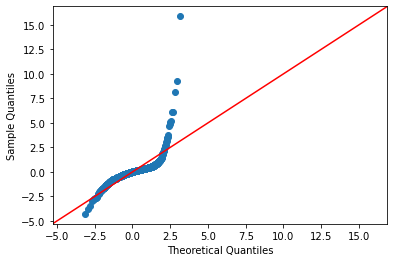

In [64]:
## Create a Q-QPlot

# first calculate residuals 
resid = y_test - y_hat_test

## then use sm's qqplot
fig, ax = plt.subplots(figsize=(6,4))
sm.graphics.qqplot(resid,line='45',fit=True,ax=ax);

### Residual Plot for Checking Homoscedasticity

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Predicted Revenue')]

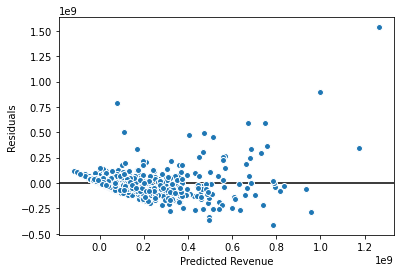

In [65]:
## Plot scatterplot with y_hat_test vs resids
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_hat_test, resid, ec='white')
ax.axhline(0,c='black',zorder=0)
ax.set(ylabel='Residuals',xlabel='Predicted Revenue')

### Putting it all together

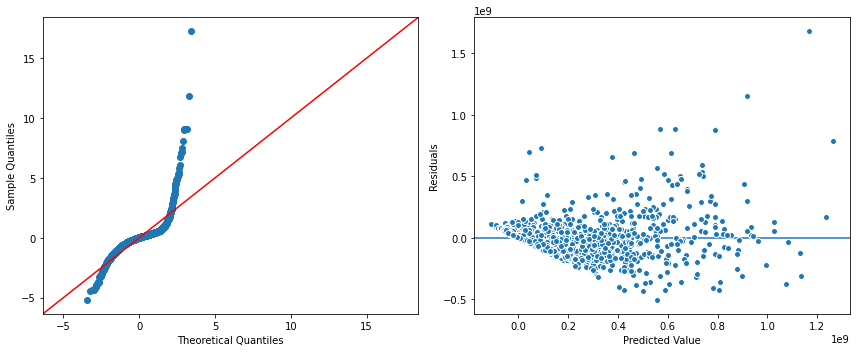

In [66]:
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
evaluate_ols(result,X_train_df, y_train)



> Next class: iterating on our model & interpreting coefficients